<a href="https://colab.research.google.com/github/Havkerr/Expression_Transfer-Google-Colab/blob/main/first_order_model_demo_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo for paper "First Order Motion Model for Image Animation"
To try the demo, press the 2 play buttons in order and scroll to the bottom. Note that it may take several minutes to load.

In [1]:
%%capture
%pip install ffmpeg-python imageio-ffmpeg
!git init .
!git remote add origin https://github.com/AliaksandrSiarohin/first-order-model
!git pull origin master
!git clone https://github.com/graphemecluster/first-order-model-demo demo


In [2]:
!git clone https://github.com/xinntao/Real-ESRGAN
%cd Real-ESRGAN
!pip install -r requirements.txt
!python setup.py develop
%cd /content

Cloning into 'Real-ESRGAN'...
remote: Enumerating objects: 759, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 759 (delta 106), reused 98 (delta 98), pack-reused 638 (from 1)
Receiving objects: 100% (759/759), 5.38 MiB | 14.69 MiB/s, done.
Resolving deltas: 100% (415/415), done.
/content/Real-ESRGAN
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Usin

Upload your high-resolution IMAGE (up to 1024x1024)


Saving Adobe Express - file (2).jpg to Adobe Express - file (2).jpg


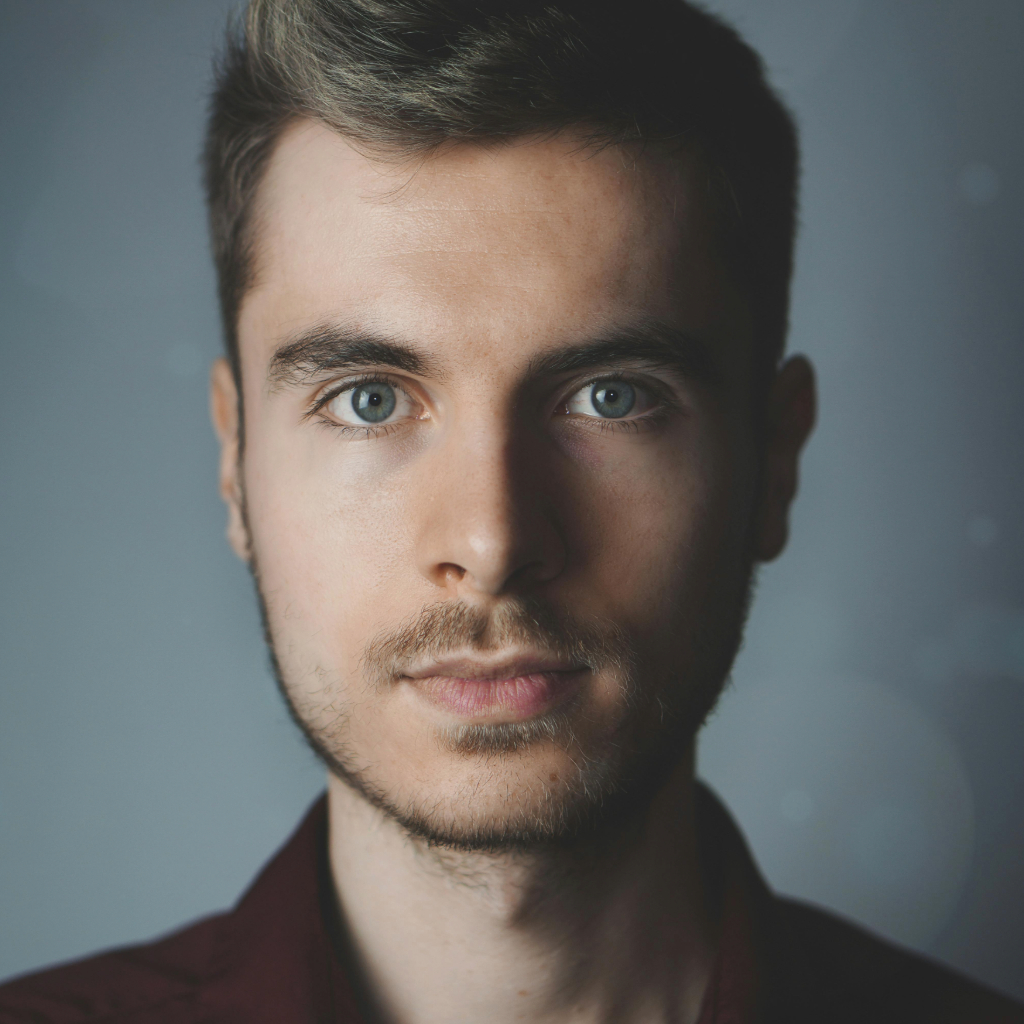

Upload your high-resolution VIDEO


Saving smile-eyeglasses.mp4 to smile-eyeglasses.mp4
✅ Image loaded: Adobe Express - file (2).jpg, size: (1024, 1024)
✅ Video loaded: smile-eyeglasses.mp4


In [2]:
from google.colab import files
from PIL import Image
import io
import cv2

# Upload high-res image
print("Upload your high-resolution IMAGE (up to 1024x1024)")
uploaded_image = files.upload()
image_name = list(uploaded_image.keys())[0]
input_image = Image.open(io.BytesIO(uploaded_image[image_name])).convert("RGB")
display(input_image)

# Upload high-res video
print("Upload your high-resolution VIDEO")
uploaded_video = files.upload()
video_name = list(uploaded_video.keys())[0]

print(f"✅ Image loaded: {image_name}, size: {input_image.size}")
print(f"✅ Video loaded: {video_name}")


✅ Downsampled both image and video to 256x256 for FOMM.


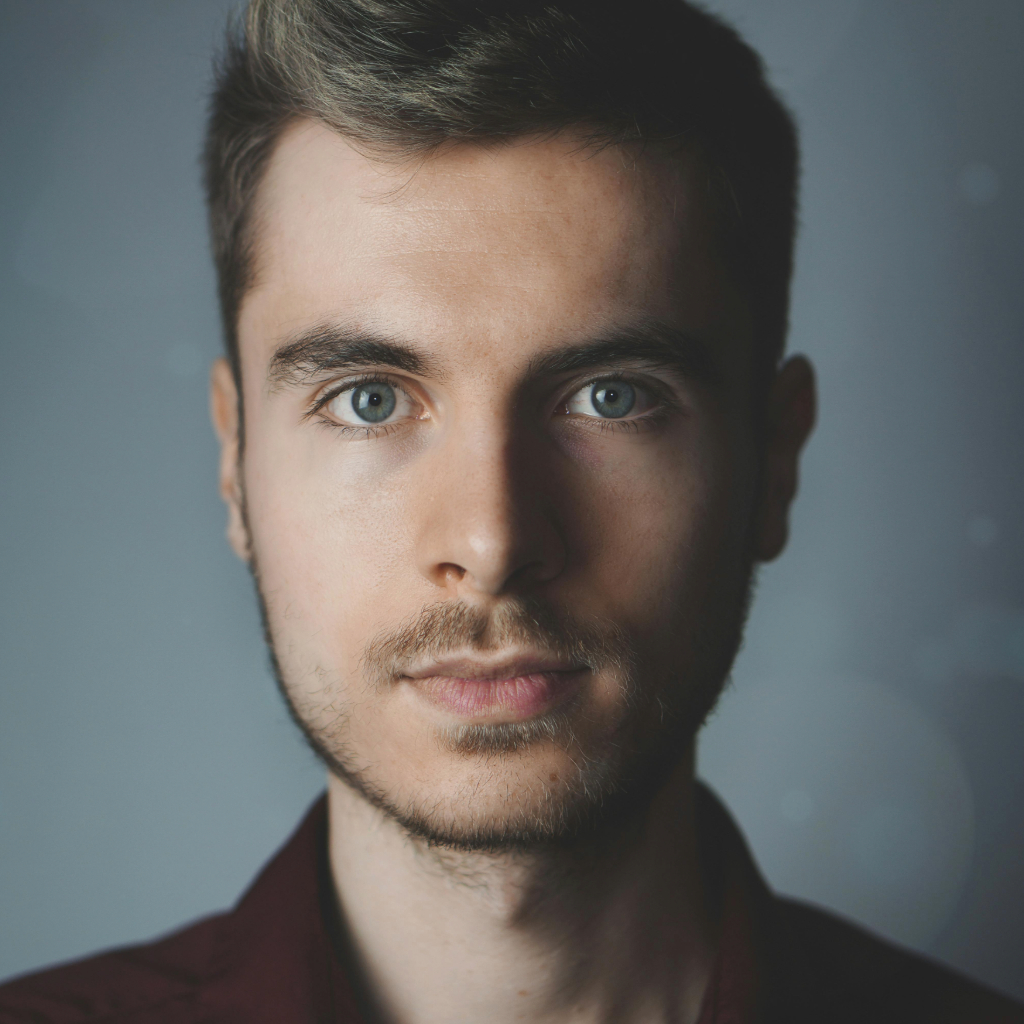

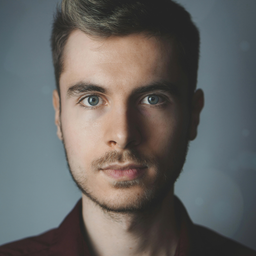

In [3]:
# Downsample image
down_image = input_image.resize((256, 256), Image.LANCZOS)

# Downsample video frame-by-frame
cap = cv2.VideoCapture(video_name)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('driving_256.mp4', fourcc, cap.get(cv2.CAP_PROP_FPS), (256, 256))

while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame_resized = cv2.resize(frame, (256, 256), interpolation=cv2.INTER_LANCZOS4)
    out.write(frame_resized)

cap.release()
out.release()

print("✅ Downsampled both image and video to 256x256 for FOMM.")

# Show before & after for image
display(input_image, down_image)


In [4]:
import imageio
import numpy as np
from skimage import img_as_ubyte
from demo import load_checkpoints, make_animation

# Load model
generator, kp_detector = load_checkpoints(
    config_path='config/vox-256.yaml',  # or your selected model config
    checkpoint_path='vox-cpk.pth.tar',  # must match config
    cpu=True
)

# Load source & driving
source = np.array(down_image) / 255.0
driving_video = [frame / 255.0 for frame in imageio.mimread('driving_256.mp4')]

# Run animation
predictions = make_animation(
    source, driving_video, generator, kp_detector,
    relative=True, adapt_movement_scale=True, cpu=True
)

# Save raw 256px output
imageio.mimsave('output_256.mp4', [img_as_ubyte(frame) for frame in predictions], fps=cap.get(cv2.CAP_PROP_FPS))
print("✅ Generated animation at 256x256.")

# Display
from IPython.display import Video
Video('output_256.mp4', embed=True)


  0%|          | 0/47 [00:00<?, ?it/s]

✅ Generated animation at 256x256.


In [28]:
import os
import cv2
import numpy as np
from IPython.display import Video as IPyVideo

# Create frame output folder
os.makedirs("enhanced_frames", exist_ok=True)

cap = cv2.VideoCapture("output_256.mp4")
fps = cap.get(cv2.CAP_PROP_FPS)
count = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break
    # Denoise
    denoised = cv2.fastNlMeansDenoisingColored(frame, None, 10, 10, 7, 21)
    # Sharpen
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    sharpened = cv2.filter2D(denoised, -1, kernel)
    cv2.imwrite(f"enhanced_frames/{count:06d}.png", sharpened)
    count += 1

cap.release()
print(f"✅ Processed and saved {count} enhanced frames.")

# Use FFmpeg to create playable MP4
!ffmpeg -y -framerate {fps} -i enhanced_frames/%06d.png \
    -c:v libx264 -pix_fmt yuv420p output_256_enhanced.mp4

print("✅ Final enhanced video saved as output_256_enhanced.mp4")

# Display
IPyVideo("output_256_enhanced.mp4", embed=True)


✅ Processed and saved 47 enhanced frames.
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab

In [1]:
import IPython.display
import PIL.Image
import cv2
import ffmpeg
import imageio
import io
import ipywidgets
import numpy
import os.path
import requests
import skimage.transform
import warnings
from demo import load_checkpoints, make_animation  # type: ignore
from google.colab import files
from IPython.display import HTML, Javascript
from shutil import copyfileobj
from skimage import img_as_ubyte
from tempfile import NamedTemporaryFile
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")
os.makedirs("user", exist_ok=True)

def resize(image, size=(256, 256)):
    w, h = image.size
    d = min(w, h)
    r = ((w - d) // 2, (h - d) // 2, (w + d) // 2, (h + d) // 2)
    return image.resize(size, resample=PIL.Image.LANCZOS, box=r)

def thumbnail(file):
    return imageio.get_reader(file, mode='I', format='FFMPEG').get_next_data()

input_image_widget = ipywidgets.Output()
input_image_widget.add_class('input-widget')
upload_input_image_button = ipywidgets.FileUpload(accept='image/*', button_style='primary')
upload_input_image_button.add_class('input-button')

input_video_widget = ipywidgets.Output()
input_video_widget.add_class('input-widget')
upload_input_video_button = ipywidgets.FileUpload(accept='video/*', button_style='primary')
upload_input_video_button.add_class('input-button')

selected_image = None
def upload_image(change):
    global selected_image
    for name, file_info in upload_input_image_button.value.items():
        content = file_info['content']
    if content is not None:
        selected_image = resize(PIL.Image.open(io.BytesIO(content)).convert("RGB"))
        input_image_widget.clear_output(wait=True)
        with input_image_widget:
            display(selected_image)
        input_image_widget.add_class('uploaded')
upload_input_image_button.observe(upload_image, names='value')

selected_video = None
def upload_video(change):
    global selected_video
    for name, file_info in upload_input_video_button.value.items():
        content = file_info['content']
    if content is not None:
        selected_video = 'user/' + name
        with open(selected_video, 'wb') as video:
            video.write(content)
        preview = resize(PIL.Image.fromarray(thumbnail(selected_video)).convert("RGB"))
        input_video_widget.clear_output(wait=True)
        with input_video_widget:
            display(preview)
        input_video_widget.add_class('uploaded')
upload_input_video_button.observe(upload_video, names='value')

model = ipywidgets.Dropdown(
    description="Model:",
    options=['vox', 'vox-adv', 'taichi', 'taichi-adv', 'nemo', 'mgif', 'fashion', 'bair']
)

relative = ipywidgets.Checkbox(description="Relative keypoint displacement", value=True)
adapt_movement_scale = ipywidgets.Checkbox(description="Adapt movement scale", value=True)
generate_button = ipywidgets.Button(description="Generate", button_style='primary')

main = ipywidgets.VBox([
    ipywidgets.Label('Upload Image'),
    ipywidgets.VBox([input_image_widget, upload_input_image_button]),
    ipywidgets.Label('Upload Video'),
    ipywidgets.VBox([input_video_widget, upload_input_video_button]),
    model,
    relative,
    adapt_movement_scale,
    generate_button
])

loader = ipywidgets.Label()
loader.add_class("loader")
loading_label = ipywidgets.Label("This may take several minutes to process…")
loading_label.add_class("loading-label")
progress_bar = ipywidgets.Output()
loading = ipywidgets.VBox([loader, loading_label, progress_bar])
loading.add_class('loading')

output_widget = ipywidgets.Output()
output_widget.add_class('output-widget')
download = ipywidgets.Button(description='Download', button_style='primary')
download.add_class('output-button')
download.on_click(lambda b: files.download('output.mp4'))

complete = ipywidgets.VBox([output_widget, download])

def generate(button):
    main.layout.display = 'none'
    loading.layout.display = ''
    filename = model.value + ('' if model.value == 'fashion' else '-cpk') + '.pth.tar'
    if not os.path.isfile(filename):
        response = requests.get('https://github.com/graphemecluster/first-order-model-demo/releases/download/checkpoints/' + filename, stream=True)
        with progress_bar:
            with tqdm.wrapattr(response.raw, 'read', total=int(response.headers.get('Content-Length', 0)), unit='B', unit_scale=True, unit_divisor=1024) as raw:
                with open(filename, 'wb') as file:
                    copyfileobj(raw, file)
    progress_bar.clear_output()
    reader = imageio.get_reader(selected_video, mode='I', format='FFMPEG')
    fps = reader.get_meta_data()['fps']
    driving_video = [frame for frame in reader]

    generator, kp_detector = load_checkpoints(
        config_path='config/%s-256.yaml' % model.value,
        checkpoint_path=filename,
        cpu=True,
        quantize=False,
        prune_model=True
    )

    with progress_bar:
        predictions = make_animation(
            skimage.transform.resize(numpy.asarray(selected_image), (256, 256)),
            [skimage.transform.resize(frame, (256, 256)) for frame in driving_video],
            generator,
            kp_detector,
            relative=relative.value,
            adapt_movement_scale=adapt_movement_scale.value,
            cpu=True
        )
    progress_bar.clear_output()
    imageio.mimsave('output.mp4', [img_as_ubyte(frame) for frame in predictions], fps=fps)
    output_widget.clear_output(True)
    with output_widget:
        display(ipywidgets.Video.from_file('output.mp4', autoplay=False))
    loading.layout.display = 'none'
    complete.layout.display = ''

generate_button.on_click(generate)

loading.layout.display = 'none'
complete.layout.display = 'none'
display(ipywidgets.VBox([main, loading, complete]))


🔧 Applying pruning...
💾 Saving pruned models...


In [ ]:
import os

gen_size = os.path.getsize("generator_pruned.pth") / (1024 * 1024)
kp_size = os.path.getsize("kp_detector_pruned.pth") / (1024 * 1024)

print(f"📦 Generator size: {gen_size:.2f} MB")
print(f"📦 KP Detector size: {kp_size:.2f} MB")
print(f"📊 Total model size: {gen_size + kp_size:.2f} MB")


📦 Generator size: 173.99 MB
📦 KP Detector size: 54.28 MB
📊 Total model size: 228.27 MB


In [ ]:
import time
import numpy as np
from skimage import transform
import imageio


if isinstance(selected_image, PIL.Image.Image):
    selected_image_np = np.asarray(selected_image.convert("RGB"))
else:
    raise ValueError("selected_image is not a valid PIL Image")


source = transform.resize(selected_image_np, (256, 256))


reader = imageio.get_reader(selected_video, mode='I')
driving = [transform.resize(frame, (256, 256)) for frame in reader]
reader.close()


checkpoint_file = model.value + ('-cpk' if model.value != 'fashion' else '') + '.pth.tar'
generator, kp_detector = load_checkpoints(
    config_path=f'config/{model.value}-256.yaml',
    checkpoint_path=checkpoint_file,
    cpu=True,
    quantize=True
)

#nference and measure time
start_time = time.time()
preds = make_animation(
    source,
    driving,
    generator,
    kp_detector,
    relative=relative.value,
    adapt_movement_scale=adapt_movement_scale.value,
    cpu=True
)
end_time = time.time()

print(f"\n🕒 Inference time: {end_time - start_time:.2f} seconds")


⚡ Applying quantization...


  0%|          | 0/55 [00:00<?, ?it/s]


🕒 Inference time: 128.41 seconds


In [ ]:
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
import numpy as np

In [ ]:

driving_resized = [skimage.transform.resize(frame, (256, 256)) for frame in imageio.get_reader(selected_video, mode='I')]

def to_numpy_img(img):
    if img.dtype != np.float32 and img.dtype != np.float64:
        img = img / 255.0
    return np.clip(img, 0, 1)
total_psnr = 0
predictions = make_animation(
    source,
    driving,
    generator,
    kp_detector,
    relative=relative.value,
    adapt_movement_scale=adapt_movement_scale.value, cpu=True
)
for pred_frame, gt_frame in zip(predictions, driving_resized):
    pred_np = to_numpy_img(pred_frame)
    gt_np = to_numpy_img(gt_frame)
    total_psnr += compare_psnr(gt_np, pred_np, data_range=1.0)

avg_psnr = total_psnr / len(predictions)
print(f"📈 Average PSNR: {avg_psnr:.2f} dB")


  0%|          | 0/55 [00:00<?, ?it/s]

📈 Average PSNR: 9.50 dB


In [ ]:
import subprocess

def get_gpu_power():
    try:
        result = subprocess.check_output(
            ['nvidia-smi', '--query-gpu=power.draw', '--format=csv,noheader,nounits']
        )
        power_draw = float(result.decode('utf-8').strip())  # in watts
        print(f"⚡ GPU Power Draw: {power_draw} W")
        return power_draw
    except Exception as e:
        print("Error using nvidia-smi:", e)
        return None

get_gpu_power()



Error using nvidia-smi: [Errno 2] No such file or directory: 'nvidia-smi'
